In [ ]:
#载入数据

!pip install kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c rsna-pneumonia-detection-challenge


KeyboardInterrupt: ignored

In [ ]:
!unzip -n '../content/rsna-pneumonia-detection-challenge.zip' -d '../content/'

In [ ]:
!pip install  pydicom
#!pip install --upgrade numpy
# import numpy as np
# print(np.__version__)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 60.9 MB/s eta 0:00:00


In [ ]:
import os
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd
import glob
from sklearn.model_selection import KFold

In [ ]:
DATA_DIR = '/content/'

# Directory to save logs and trained model
ROOT_DIR = '/content/working'

### Install Matterport's Mask-RCNN model from github.


In [ ]:
!git clone https://github.com/leekunhee/Mask_RCNN.git
os.chdir('Mask_RCNN')

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 983, done.
remote: Total 983 (delta 0), reused 0 (delta 0), pack-reused 983
Receiving objects: 100% (983/983), 149.27 MiB | 31.77 MiB/s, done.
Resolving deltas: 100% (572/572), done.


In [ ]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [ ]:
train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')

### Download COCO pre-trained weights

In [ ]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw-r--r-- 1 root root 246M Dec  6  2021 mask_rcnn_coco.h5


### Some setup functions and classes for Mask-RCNN



In [ ]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns):
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows():
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations

In this configuration class, these parameters are set to simplified version values for demonstration, and may need to be adjusted according to specific needs in actual applications

In [ ]:
class DetectorConfig(Config):
    """针对RSNA肺炎数据集训练肺炎检测模型的配置
    重写了Config类中的某些属性
    """

    # 为配置起一个可识别的名称
    NAME = 'pneumonia'

    # 使用1个GPU，每个GPU处理8张图片。由于图片较小，可以将多张图片放到每个GPU上。批处理大小为8（GPU数 * 每个GPU的图片数）。
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # 使用ResNet50作为主干网络
    BACKBONE = 'resnet50'

    # 类别数为2，包括背景和肺炎
    NUM_CLASSES = 2

    # 缩放图像，使最小边为256，最大边为256
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # RPN网络使用4个不同的尺度来检测物体
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)

    # 每张图片训练时使用32个Region of Interest (RoI)
    TRAIN_ROIS_PER_IMAGE = 32

    # 最大正样本个数
    MAX_GT_INSTANCES = 4

    # 每张图片最多检测出3个物体实例
    DETECTION_MAX_INSTANCES = 3

    # 模型预测框的置信度阈值
    DETECTION_MIN_CONFIDENCE = 0.78  ## 匹配目标分布

    # 非极大抑制的IoU阈值
    DETECTION_NMS_THRESHOLD = 0.01

    # 每个epoch包含200个step
    STEPS_PER_EPOCH = 200

# 使用DetectorConfig配置参数并显示
config = DetectorConfig()
config.display()



Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

Load and process the pneumonia detection dataset

In [ ]:
class DetectorDataset(utils.Dataset):
    """用于 RSNA 肺炎检测数据集训练的数据集类"""

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)

        # 添加类别
        self.add_class('pneumonia', 1, 'Lung Opacity')

        # 添加图像信息
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp,
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)

    def image_reference(self, image_id):
        """返回图像的路径"""
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        """加载图像"""
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # 如果是灰度图像，则将其转换为 RGB 图像，以便与其他彩色图像保持一致
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        """加载掩码"""
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)


### Examine the annotation data, parse the dataset, and view dicom fields

In [ ]:
# training dataset
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
anns.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [ ]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [ ]:
ds = pydicom.read_file(image_fps[0])
file_meta_dict = {elem.keyword: elem.value for elem in ds.file_meta}
print(file_meta_dict)


{'FileMetaInformationGroupLength': 202, 'FileMetaInformationVersion': b'\x00\x01', 'MediaStorageSOPClassUID': '1.2.840.10008.5.1.4.1.1.7', 'MediaStorageSOPInstanceUID': '1.2.276.0.7230010.3.1.4.8323329.30988.1517874505.436232', 'TransferSyntaxUID': '1.2.840.10008.1.2.4.50', 'ImplementationClassUID': '1.2.276.0.7230010.3.0.3.6.0', 'ImplementationVersionName': 'OFFIS_DCMTK_360'}


In [ ]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

### Split the data into training and validation datasets

In the early stage of the experiment, in order to reduce the training time and detect whether it can run normally, I reduced the amount of training, and only used the first 29% of the data for training, and 29% to 30% of the data for testing

In [ ]:
# #拆分为训练集和测试集
# # 将数据集中所有图像的文件路径保存在`image_fps`列表中
# image_fps_list = list(image_fps)
# random.seed(42)
# random.shuffle(image_fps_list)

# # 计算前29%的数量
# num_train_samples = 29

# # 计算前29%到前30%的数量
# num_val_samples = 1

# # 将前29%的元素作为训练集
# image_fps_train = image_fps[:num_train_samples]

# # 将前29%到前30%的元素作为测试集
# image_fps_val = image_fps[num_train_samples:num_train_samples+num_val_samples]

# # 将剩下的70%的元素删除
# #image_fps = image_fps[:num_train_samples+num_val_samples]

# print(len(image_fps_train), len(image_fps_val))
# print(len(image_fps_train)/len(image_fps_val))

In [ ]:
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)
val_size = 1500
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))
# print(len(image_fps_train)/len(image_fps_val))
# print(image_fps_val[:6])

25184 1500


Create and prepare the training dataset using the DetectorDataset class.

In [ ]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

 Create and prepare the validation dataset using the DetectorDataset class.

In [ ]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

### Display a random image with bounding boxes

<ipython-input-12-bd557acb3043>:53: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), class_ids.astype(np.int32)


(1024, 1024, 3)
/content/stage_2_train_images/697ba0dd-6546-43b5-bfe6-f331fb96e0fe.dcm
[1]


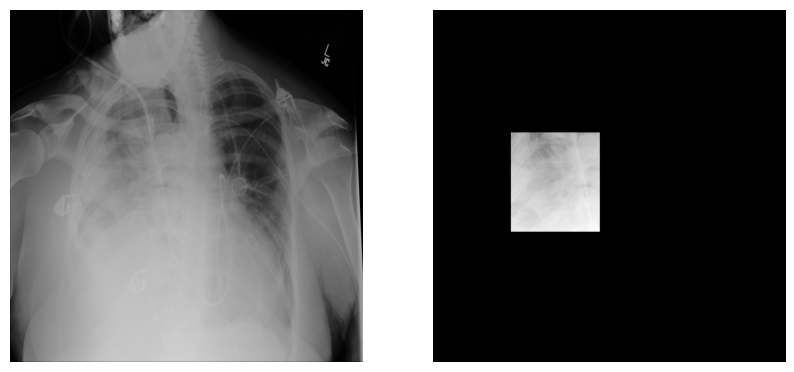

In [ ]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

### image enhancement

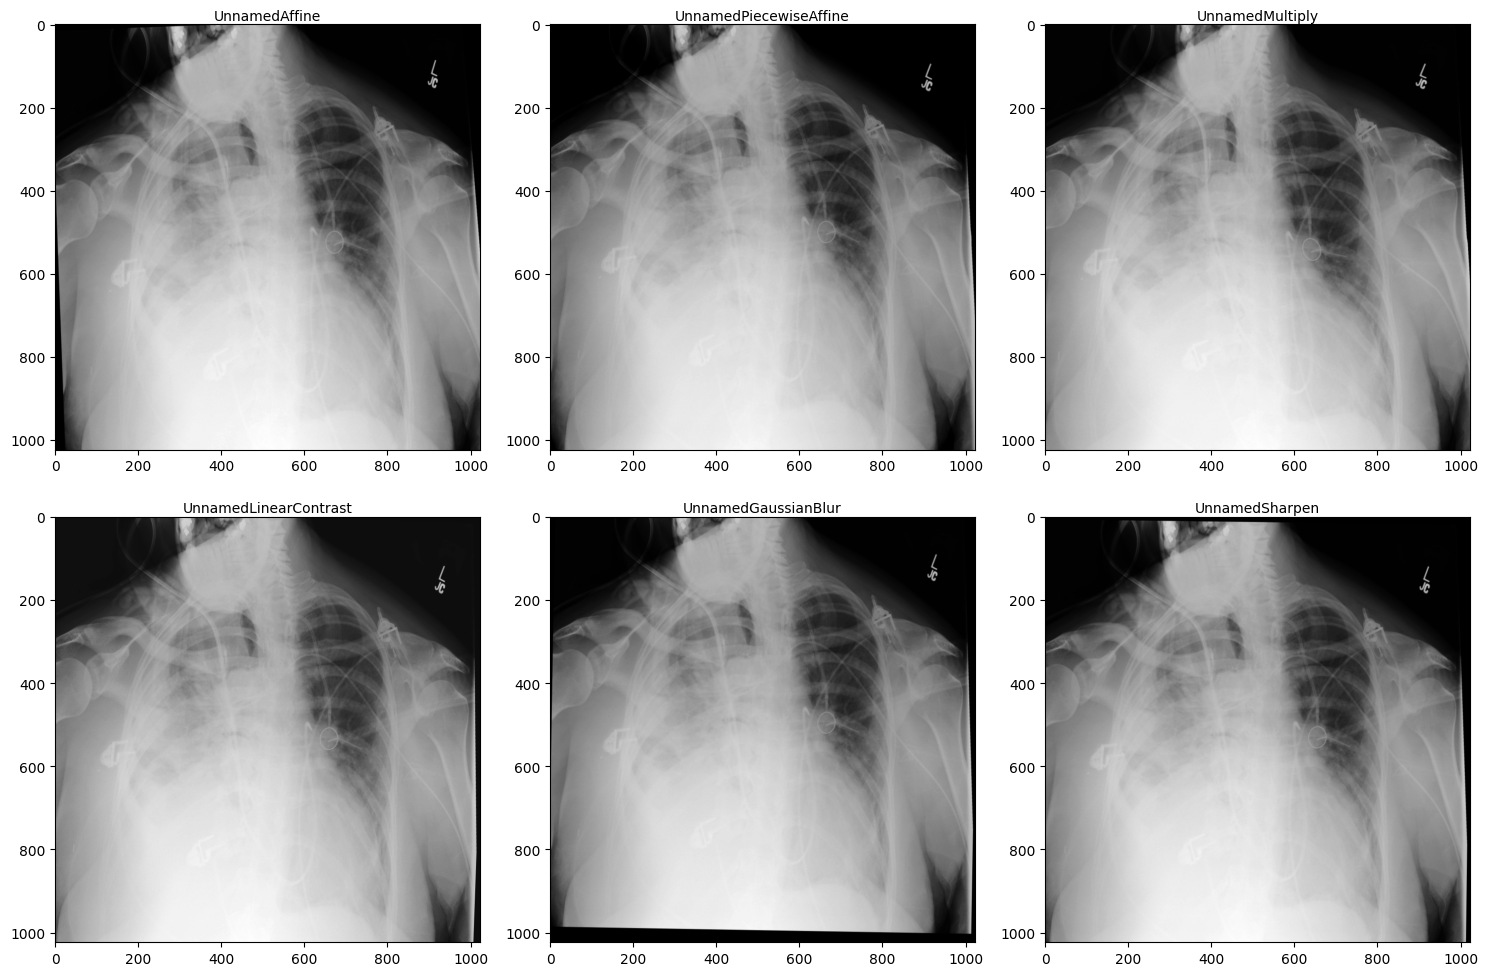

In [ ]:
import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt

# define image augmentation pipeline
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
image_aug, title_aug = [], []
for i in range(6):
    img = augmentation.augment_image(image[:, :, 0])
    title = augmentation[i // 2][i % 2].name
    image_aug.append(img)
    title_aug.append(title)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(image_aug[i], cmap='gray')
    ax.set_title(title_aug[i], fontsize=10, pad=3)
plt.tight_layout()
plt.show()


### train the model.



- dataset_train and dataset_val are derived from DetectorDataset
- DetectorDataset loads images from image filenames and  masks from the annotation data
- model is Mask-RCNN

In [ ]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
LEARNING_RATE = 0.006

# Train Mask-RCNN Model
import warnings
warnings.filterwarnings("ignore")

In [ ]:
%%time
## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=2,
            layers='heads',
            augmentation=None)  ## no need to augment yet

history = model.keras_model.history.history


Starting at epoch 0. LR=0.012

Checkpoint Path: /kaggle/working/pneumonia20190702T0812/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4 

In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=6,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 2. LR=0.006

Checkpoint Path: /kaggle/working/pneumonia20190702T0812/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b  

In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/5,
            epochs=16,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 6. LR=0.0012000000000000001

Checkpoint Path: /kaggle/working/pneumonia20190702T0812/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)

In [ ]:
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,1.946854,0.031487,0.693769,0.214321,0.597003,0.410272,1.823529,0.027753,0.575787,0.267288,0.541263,0.411436
2,1.929175,0.023780,0.868914,0.200593,0.447650,0.388232,1.839756,0.025579,0.701061,0.238327,0.482655,0.392131
3,1.756589,0.024137,0.624220,0.271979,0.450950,0.385289,1.789226,0.022452,0.630046,0.262430,0.464801,0.409486
4,1.613158,0.015386,0.499803,0.253540,0.459370,0.385043,1.640905,0.020456,0.528593,0.247765,0.442707,0.401368
5,1.721350,0.021225,0.637577,0.265907,0.426047,0.370576,1.583750,0.018860,0.492725,0.236142,0.437181,0.398827
6,1.862439,0.020442,0.711252,0.294781,0.453607,0.382338,1.581114,0.017706,0.490512,0.247800,0.429457,0.395621
7,1.510706,0.017184,0.546795,0.183418,0.389289,0.374001,1.456361,0.014699,0.432355,0.228198,0.394621,0.386470
8,1.320470,0.011504,0.369017,0.181782,0.386946,0.371203,1.319434,0.012102,0.355022,0.204722,0.368766,0.378803
9,1.388407,0.013737,0.473610,0.166606,0.368889,0.365546,1.350969,0.012975,0.376266,0.198117,0.379924,0.383668
10,1.474691,0.014926,0.527488,0.183004,0.382210,0.367044,1.291200,0.011189,0.337158,0.200826,0.362751,0.379258


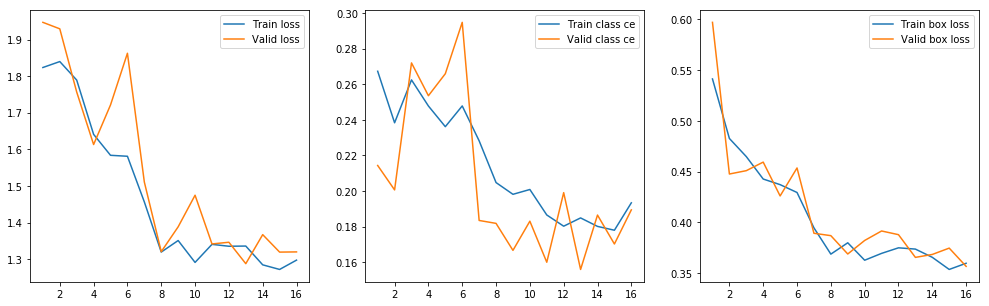

In [ ]:
plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

In [ ]:
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

Best Epoch: 13 1.2877648568153381


In [ ]:
# select trained model
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))

fps = []
# Pick last directory
for d in dir_names:
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /kaggle/working/pneumonia20190702T0812/mask_rcnn_pneumonia_0013.h5


In [ ]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference',
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /kaggle/working/pneumonia20190702T0812/mask_rcnn_pneumonia_0013.h5
Re-starting from epoch 13


In [ ]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

### How does the predicted box compared to the expected value? Let's use the validation dataset to check.



(256, 256, 3)
(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)
(256, 256, 3)


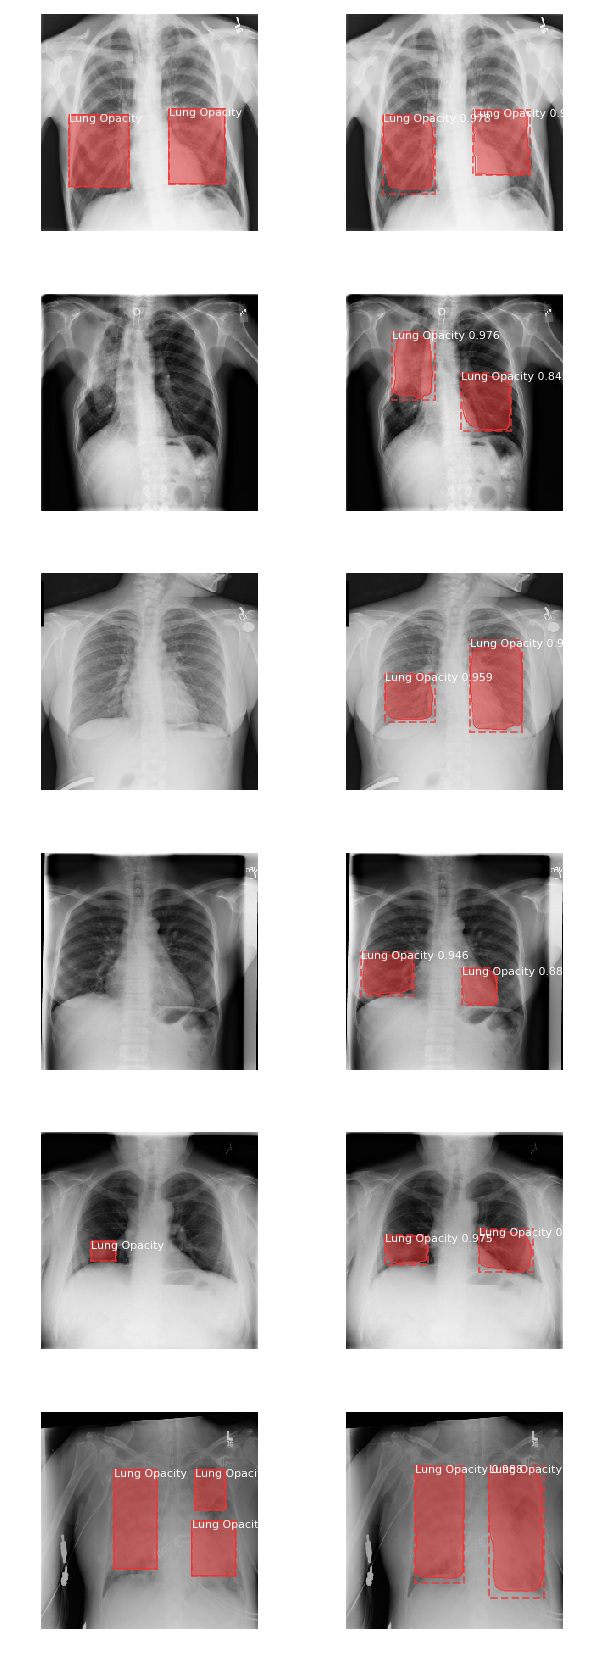

In [ ]:
# Show few example of ground truth vs. predictions on the validation dataset
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)

    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)

    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])

    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                                dataset.class_names, r['scores'],
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])